# Watermark Images
Reference implementation: https://github.com/MachineLearningVisionRG/KMsWA2

Reference paper: https://doi.org/10.3390/jimaging8060155

In [1]:
import glob
import math
import os
import time

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy.special import poch

# Load Data

Image Count: 11179

datasets\ctscan\raw\COVID\Covid (1).png


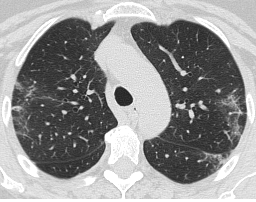

In [2]:
base_query = "datasets/**/raw/**/"
images = []
images += glob.glob(base_query + "*.png", recursive=True)
images += glob.glob(base_query + "*.jpg", recursive=True)

print("Image Count:", len(images))
print()
print(images[0])
Image.open("datasets/ctscan/raw/COVID/Covid (1).png")

# Krawtchouk Moments Watermark

## Generate Watermark

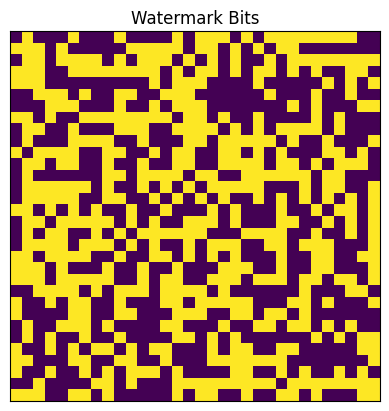

In [3]:
np.random.seed(42)
WATERMARK_BITS = np.random.choice([0, 1], size=(1024,))
#WATERMARK_BITS = np.ones((1024,))
#WATERMARK_BITS = np.indices((1024,)).sum(axis=0)%2

frame = plt.gca()
frame.imshow(np.reshape(WATERMARK_BITS, (32, 32)), interpolation='nearest')
frame.axes.xaxis.set_ticks([])
frame.axes.yaxis.set_ticks([])
plt.title("Watermark Bits")
plt.show()

This watermark should be embeddable and retrievable.

## Helpers

In [4]:
#

def dither(z_pq_v_c, b_seq, delta, d_0):
    z_pq_mod_v = np.zeros(1)
    z_pq_magn_v_c = abs(z_pq_v_c)

    for i in range(2):
        d_1 = delta/2 + d_0
        if b_seq == 1:
            z_pq_magn_mod_v = np.round(((z_pq_magn_v_c - d_1) / delta)) * delta + d_1
            z_pq_mod_v = (z_pq_magn_mod_v / z_pq_magn_v_c) * z_pq_v_c
        else:
            z_pq_magn_mod_v = np.round(((z_pq_magn_v_c - d_0) / delta)) * delta + d_0
            z_pq_mod_v = (z_pq_magn_mod_v / z_pq_magn_v_c) * z_pq_v_c

        min_dist = (z_pq_magn_mod_v - z_pq_magn_v_c) ** 2
    return z_pq_mod_v, min_dist

In [5]:
# https://github.com/MachineLearningVisionRG/KMsWA2/blob/main/KMsWA2/zigzag.py


def zigzag(in_):
    h = 0
    v = 0
    vmin = 0
    hmin = 0
    vmax = in_.shape[0]
    hmax = in_.shape[1]
    i = 0
    output = np.zeros((vmax * hmax))

    while ((v <= vmax) and (h <= hmax) ):
        if ((h + v) % 2) == 0:  # going up
            if (v == vmin):
                output[i] = in_[v, h]  # if we got to the first line
                if (h == hmax - 1):
                    v = v + 1
                else:
                    h = h + 1

                i = i + 1

            elif ((h == hmax - 1) and (v < vmax)):  # if we got to the last column
                output[i] = in_[v, h]
                v = v + 1
                i = i + 1

            elif ((v > vmin) and (h < hmax - 1)):  # all other cases
                output[i] = in_[v, h]
                v = v - 1
                h = h + 1
                i = i + 1


        else:  # going down

            if ((v == vmax - 1) and (h <= hmax - 1)):  # if we got to the last line
                output[i] = in_[v, h]
                h = h + 1
                i = i + 1

            elif (h == hmin):  # if we got to the first column
                output[i] = in_[v, h]
                if (v == vmax - 1):
                    h = h + 1
                else:
                    v = v + 1

                i = i + 1

            elif ((v < vmax - 1) and (h > hmin)):  # all other cases
                output[i] = in_[v, h]
                v = v + 1
                h = h - 1
                i = i + 1

        if ((v == vmax - 1) and (h == hmax - 1)):  # bottom right element
            output[i] = in_[v, h]
            break

    return output


def inverse_zigzag(in_, vmax, hmax):
    h = 0
    v = 0
    vmin = 0
    hmin = 0
    output = np.zeros((vmax, hmax))
    i = 0
    while (v < vmax) and (h < hmax):
        if ((h + v) % 2) == 0:  # going up

            if v == vmin:
                output[v, h] = in_[i]  # if we got to the first line

                if h == hmax-1:
                    v = v + 1
                else:
                    h = h + 1

                i = i + 1

            elif (h == hmax - 1) and (v < vmax):  # if we got to the last column
                output[v, h] = in_[i]
                v = v + 1
                i = i + 1

            elif (v > vmin) and (h < hmax - 1):  # all other cases
                output[v, h] = in_[i]
                v = v - 1
                h = h + 1
                i = i + 1

        else:  # going down

            if (v == vmax - 1) and (h <= hmax - 1):  # if we got to the last line
                output[v, h] = in_[i]
                h = h + 1
                i = i + 1

            elif h == hmin:  # if we got to the first column
                output[v, h] = in_[i]
                if v == vmax - 1:
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1

            elif (v < vmax - 1) and (h > hmin):  # all other cases
                output[v, h] = in_[i]
                v = v + 1
                h = h - 1
                i = i + 1

        if (v == vmax - 1) and (h == hmax - 1):  # bottom right element
            output[v, h] = in_[i]
            break

    return output

In [6]:
# https://github.com/MachineLearningVisionRG/KMsWA2/blob/main/KMsWA2/KMs.py

def KMrec(N, M, p1, p2, Q, order):
    Kn = Krawtchouk_bar_poly(p1, order, N - 1)
    Km = Krawtchouk_bar_poly(p2, order, M - 1)

    Rec_F = np.zeros(shape=(N, M))
    for x in range(N):
        for y in range(M):
            Rec_F[x, y] = np.sum((Kn[:, x] * Km[:, y].reshape(-1, 1)) * Q)

    return Rec_F

def KMs(img, p, q, p1, p2, mthd):
    if mthd == 'Direct':
        Moms, Pols = Direct_mthd(img, p, q, p1, p2)
    else:
        print('This method is not supported')
    return Moms, Pols

def Direct_mthd(img, order, rep, p1, p2):
    Pols = []
    N, M = img.shape
    Moms = np.zeros(shape=(order + 1, rep + 1))

    Kp = Krawtchouk_bar_poly(p1, order, N - 1)
    Kq = Krawtchouk_bar_poly(p2, rep, M - 1)

    for p in range(order + 1):
        for q in range(rep + 1):
            Moms[p, q] = np.sum(((Kp[p,:].reshape(-1,1)) * Kq[q,:]) * img)
    
    # print(Moms.shape)
    Pols1 = Kp
    Pols2 = Kq
    Pols.append(Pols1)
    Pols.append(Pols2)
    return Moms, Pols

def Weight_Function(p, N):
    w = np.zeros(shape=(N+1), dtype=np.float64)
    w[0] = (1 - p) ** N
    for x in range(N):
        w[x + 1] = ((N-x)/(x+1))*(p/(1-p)) * w[x]

    return w

def p_norm(n, p, N):
    poch_term = poch(-N,n)
    pnorm = ((-1)**n) * (((1-p)/p)**n) * (math.factorial(n)/poch_term)
    return pnorm

# We store a cache since the base Krawtchouk polynomial values are the same
# for images with the same (p1, p2), order, and (width, height).
# Since these values are shared by a lot of images, it make sense to cache
# the values for performance reasons.
KBP_cache = {}

def Krawtchouk_bar_poly(p, nmax, N):
    if (p, nmax, N) in KBP_cache:
        return KBP_cache[(p, nmax, N)]
    else:
        w = Weight_Function(p, N)
        
        x = np.arange(N + 1)
        K = np.zeros(shape=(nmax + 1, N + 1), dtype=np.float64)
        if nmax == 0:
            K[0, :] = np.sqrt(w / p_norm(0, p, N))
        elif nmax == 1:
            x1 = (1-(x/(p*N)))
            y = p_norm(1, p, N)
            x2 = np.sqrt(w / y)
            K[1, :] = x1 * x2
        else:
            K[0, :] = np.sqrt(w / p_norm(0, p, N))
            x1 = (1 - (x / (p * N)))
            x2 = np.sqrt(w / p_norm(1, p, N))
            K[1, :] = (x1 * x2)
            for n in range(1, nmax):
                A = np.sqrt(p * (N - n) / ((1 - p) * (n + 1)))
                B = np.sqrt((p ** 2) * (N - n) * (N - n + 1) / (((1 - p) ** 2) * (n + 1) * n))
                x3 = A * (N * p - 2 * n * p + n - x)
                x4 = (K[n, :] - B * n * (1 - p) * K[n-1, :]) / (p * (N - n))
                K[n + 1, :] = (A * (N * p - 2 * n * p + n - x) * K[n, :] - B * n * (1 - p) * K[n-1, :]) / (p * (N - n))

        KBP_cache[(p, nmax, N)] = K

        return K

In [7]:
def plot_img(img, title):
    frame = plt.gca()
    frame.imshow(img, interpolation='nearest')
    frame.axes.xaxis.set_ticks([])
    frame.axes.yaxis.set_ticks([])
    plt.title(title)
    plt.show()

# https://github.com/MachineLearningVisionRG/KMsWA2/blob/main/KMsWA2/insertion_KMs.py
def insertion_KMs(img, b_seq, order, delta, p1, p2, numbits, show_figs):
    # Moments Calculation
    moments, KPols = KMs(img, order, order, p1, p2, 'Direct')

    print("Moments shape:", moments.shape)

    # Moments choice
    mom_all_orig_v = zigzag(moments)
    water_info = np.zeros(shape=(mom_all_orig_v.shape[0]))
    mom_all_mod = [0]
    for i in range(1, len(b_seq[:numbits]) + 1):
        mom_all_mod_list, min_dist = dither(mom_all_orig_v[i], b_seq[i-1], delta, delta/2)
        mom_all_mod.append(mom_all_mod_list)
        water_info[i] = mom_all_mod[i] - mom_all_orig_v[i]

    water_info = inverse_zigzag(water_info, moments.shape[0], moments.shape[1])
    Rec_F = KMrec(img.shape[0], img.shape[1], p1, p2, water_info, order)
    watermarked_img = img + Rec_F
    
    if show_figs:
        plot_img(img, "Image")
        plot_img(moments, "Moments")
        plot_img(Rec_F, "Rec_F")
        plot_img(water_info, "Watermark Info")
        plot_img(watermarked_img, "Watermarked Image")
    
    return watermarked_img

In [8]:
def KM_watermark(path, b_seq, order, delta, p1, p2, numbits, show_figs=False):
    pil_img = Image.open(path).convert('L') # convert to greyscale
    np_img = np.array(pil_img)
    watermarked = insertion_KMs(np_img, b_seq, order, delta, p1, p2, numbits, show_figs)
    out_img = Image.fromarray(watermarked).convert('RGB')
    return out_img

## Watermark Datasets

In [9]:
# Parameters
P1 = 0.5
P2 = 0.5
STRENGTH = 200
NBITS = 1024
ORDER = 32

### Test Img 1

Moments shape: (33, 33)


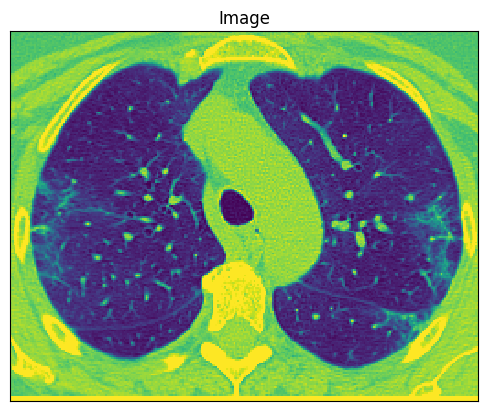

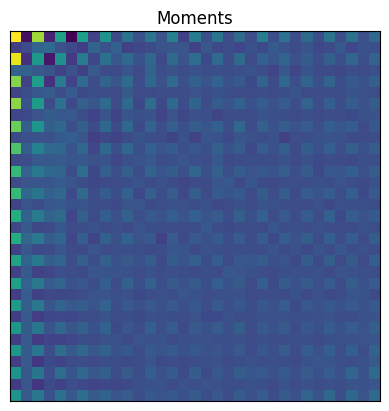

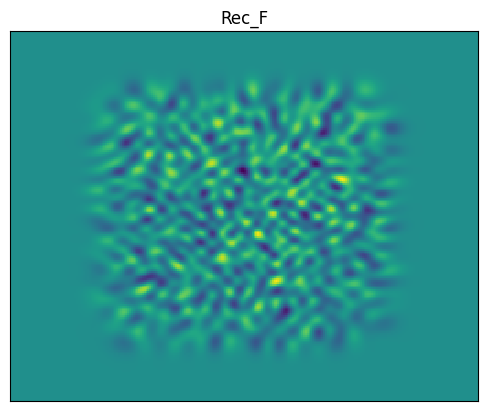

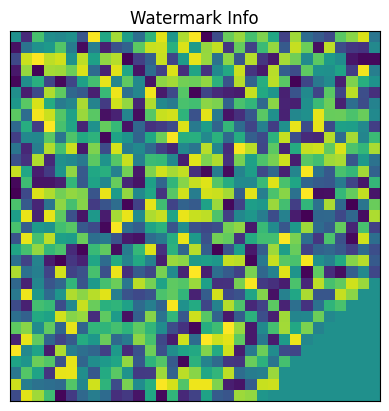

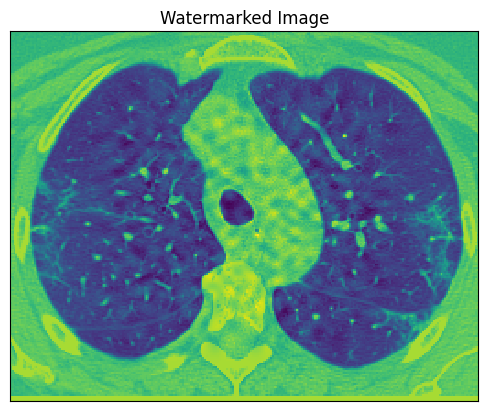

In [10]:
# Watermark
watermarked_test = KM_watermark(images[0], WATERMARK_BITS, ORDER, STRENGTH, P1, P2, NBITS, show_figs=True)

### Watermark Entire Dataset

In [11]:
def watermark_a(path, bits, order, strength, p1, p2, nbits):
    in_path = path
    comps = path.split("raw")
    
    out_path = os.path.join("", *comps[:-1])
    out_path = os.path.join(out_path, "watermark-a")
    s = comps[-1].split(os.path.sep)
    out_path = os.path.join(out_path, *s)
    
    directory = os.path.dirname(out_path)
    if not os.path.exists(directory):
        print("Made directory:", directory)
        os.makedirs(directory, exist_ok=True)

    watermarked_image = KM_watermark(in_path, bits, order, strength, p1, p2, nbits)
    watermarked_image.save(out_path)

In [ ]:
t0 = time.time()

for i, path in enumerate(images):
    elapsed = time.time() - t0
    estimated = len(images) * (elapsed / (i+1))
    remaining = estimated-elapsed
    print(f"Processing... [{i+1}/{len(images)}] (Remaining: {remaining:.2f}s)", end="\r")
    watermark_a(path, WATERMARK_BITS, ORDER, STRENGTH, P1, P2, NBITS)